In [8]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family']="Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("C:/Users/user-pc/Documents/ai-proj2-class4/20.data-preprocessing/대기오염물질_데이터셋/대기오염물질_데이터셋.csv", encoding="UTF-8")

df.head()

,datetime,region,no2,co,so2,o3,temperature,wind_direction,wind_speed,precipitation,humidity,id,pm10,pm25,diesel,electric,gasoline
0,2017-01-01 01:00:00,강남구,0.040,0.8,0.005,0.002,1.4,69.1,1.3,0.0,78.0,1590571,63.0,48.0,1112698,1589,1600398
1,2017-01-01 01:00:00,강동구,0.042,0.9,0.004,0.002,-0.2,358.9,1.3,0.0,88.0,1590572,68.0,53.0,1112698,1589,1600398
2,2017-01-01 01:00:00,강북구,0.046,1.2,0.004,0.001,1.4,338.8,0.5,0.0,81.0,1590573,63.0,51.0,1112698,1589,1600398
3,2017-01-01 01:00:00,강서구,0.070,1.3,0.007,0.002,2.9,116.9,1.8,0.0,NaN,1590574,107.0,65.0,1112698,1589,1600398
4,2017-01-01 01:00:00,관악구,0.075,1.5,0.006,0.004,1.1,178.2,1.8,0.0,93.0,1590575,75.0,57.0,1112698,1589,1600398


In [9]:
import json
from sqlalchemy import create_engine 
from sqlalchemy.exc import SQLAlchemyError
import cryptography

with open('C:/Users/user-pc/Documents/ai-proj2-class4/20.data-preprocessing/대기오염물질_데이터셋/db-config.json', 'r') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")
conn = engine.connect()

df.to_sql(
    name='air_pollution_dateset',    # 같은 테이블에 덮어쓰기
    con=engine,
    if_exists='replace',  # 삭제 후 생성
    index=False
)

print("대기오염물질 데이타셋 DB 저장")

대기오염물질 데이타셋 DB 저장


In [10]:
df = df[['datetime', 'region', 'co', 'so2', 'no2', 'o3']]

df.head()

,datetime,region,co,so2,no2,o3
0,2017-01-01 01:00:00,강남구,0.8,0.005,0.040,0.002
1,2017-01-01 01:00:00,강동구,0.9,0.004,0.042,0.002
2,2017-01-01 01:00:00,강북구,1.2,0.004,0.046,0.001
3,2017-01-01 01:00:00,강서구,1.3,0.007,0.070,0.002
4,2017-01-01 01:00:00,관악구,1.5,0.006,0.075,0.004


In [11]:
target_regions = ['중랑구', '구로구', '관악구', '강북구', '용산구']

df=df[df['region'].isin(target_regions)]

In [12]:
df

,datetime,region,co,so2,no2,o3
2,2017-01-01 01:00:00,강북구,1.2,0.004,0.046,0.001
4,2017-01-01 01:00:00,관악구,1.5,0.006,0.075,0.004
6,2017-01-01 01:00:00,구로구,1.3,0.007,0.045,0.003
20,2017-01-01 01:00:00,용산구,1.4,0.005,0.039,0.002
24,2017-01-01 01:00:00,중랑구,0.8,0.005,0.040,0.002
...,...,...,...,...,...,...
1401602,2023-12-31 00:00:00,강북구,0.6,0.002,0.022,0.019
1401604,2023-12-31 00:00:00,관악구,0.6,0.002,0.032,0.011
1401606,2023-12-31 00:00:00,구로구,0.5,0.002,0.025,0.007
1401620,2023-12-31 00:00:00,용산구,0.6,0.002,0.034,0.010


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras import Input
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# 1. datetime 변환
df['datetime'] = pd.to_datetime(df['datetime'])

# 2. 대상 지역 및 대기오염 변수
regions = ['중랑구', '구로구', '관악구', '강북구', '용산구']
target_cols = ['co', 'so2', 'no2', 'o3']

# 시계열 시퀀스 생성 함수
def create_sequences(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# LSTM 예측 함수
def lstm_forecast(series, region, pollutant):
    #결측치 제거 후, d : day 일별로 평균을 내어 분석
    series = series.dropna().resample('d').mean()
    #spline, order=3 : 3차 함수형태의 스플라인, 곡선형태의 함수로 결측치를 채움 
    series = series.interpolate(method='spline', order=3).dropna()

    # 정규화
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1, 1))

    X, y = create_sequences(scaled, window_size=48)

    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    #LSTM은 GPU 사용 시 빠르게 분석되므로 LSTM 분석 시에만 GPU 사용하도록 설정
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

    model = Sequential()
    model.add(Input(shape=(48, 1)))
    #이중 딥러닝으로 더 깊게, 자세히 분석
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    #이상치가 다소 있으므로 민감하게 분석할 수 있는 tanh 기법 사용
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss='mse')
    #최적의 값을 찾을 시 즉시 멈추고 최적의 값 저장
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 50회 반복하여 모델 학습
    model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_split=0.1,
          callbacks=[early_stop],
          verbose=1)

    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 성능 출력 / RMSE 값이 낮을수록 성능 우수
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"[{region} - {pollutant}] LSTM RMSE: {rmse:.6f}")

    # 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv[:100], label='Actual', linewidth=2)
    plt.plot(y_pred_inv[:100], label='Predicted', linewidth=2)
    plt.title(f"LSTM - {region} - {pollutant.upper()}")
    plt.legend()
    plt.grid()
    plt.show()

# ARIMA 예측 함수
def arima_forecast(series, region, pollutant):
    series = series.dropna().resample('d').mean()
    series = series.interpolate(method='time').dropna()
    
    if len(series) < 500:
        print(f"[{region} - {pollutant}] SARIMAX 데이터 부족")
        return

    # 최근 5000개만 사용 >> 5000일 = 약 13.7년
    series = series[-5000:]

    try:
        # SARIMAX 모델 수동 지정
        model = SARIMAX(
            series,
            order=(1, 1, 1),
            seasonal_order=(0, 1, 1, 24),
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        results = model.fit(verbose=1)

        # 48시간 예측
        forecast = results.get_forecast(steps=48)
        pred = forecast.predicted_mean
        conf_int = forecast.conf_int()

        # 시각화
        plt.figure(figsize=(12, 4))
        plt.plot(series[-100:], label='Observed')
        plt.plot(pred.index, pred, label='Forecast', color='red')
        plt.fill_between(pred.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
        plt.title(f"SARIMAX Forecast - {region} - {pollutant.upper()}")
        plt.legend()
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"[{region} - {pollutant}] SARIMAX 실패: {e}")


====== 중랑구 분석 시작 ======

▶ CO 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0451 - val_loss: 0.0106
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0135 - val_loss: 0.0072
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0118 - val_loss: 0.0073
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0119 - val_loss: 0.0067
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0123 - val_loss: 0.0060
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0116 - val_loss: 0.0061
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0109 - val_loss: 0.0076
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0115 - val_loss: 0.0069
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0111 - val_loss: 0.0058
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0104 - val_loss: 0.0066
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 12/50
57/57 ━━━━

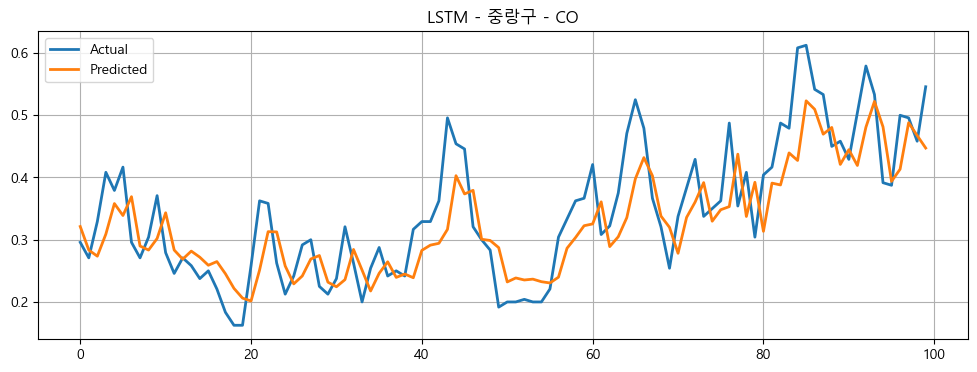

▶ CO 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


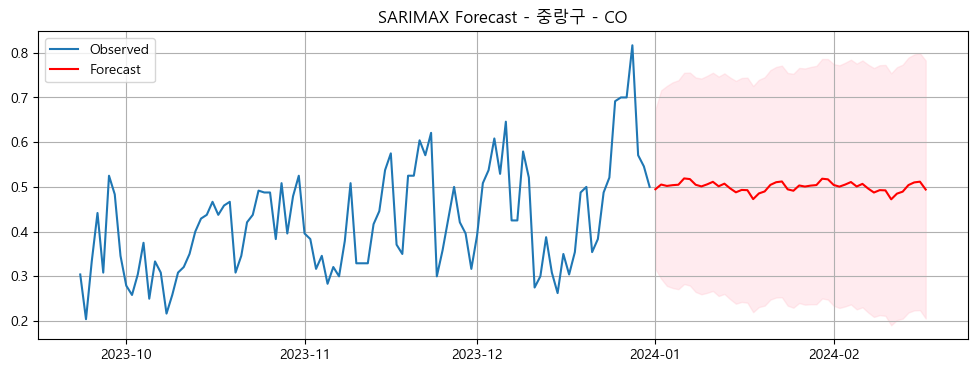


▶ SO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0755 - val_loss: 0.0037
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0052 - val_loss: 0.0038
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[중랑구 -

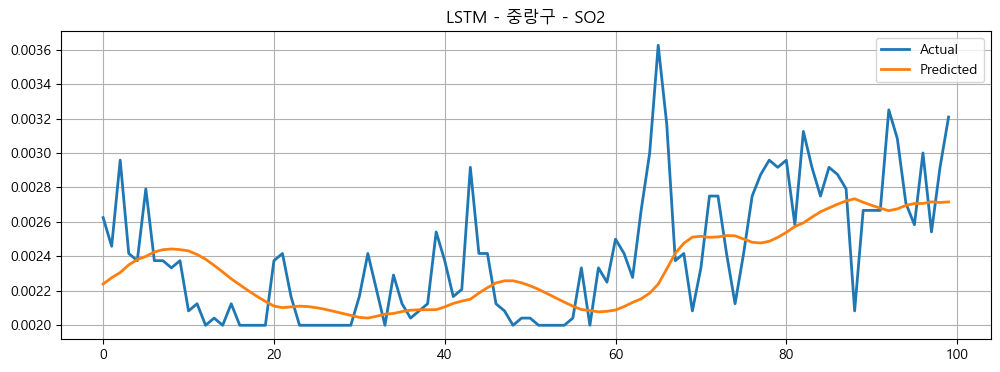

▶ SO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


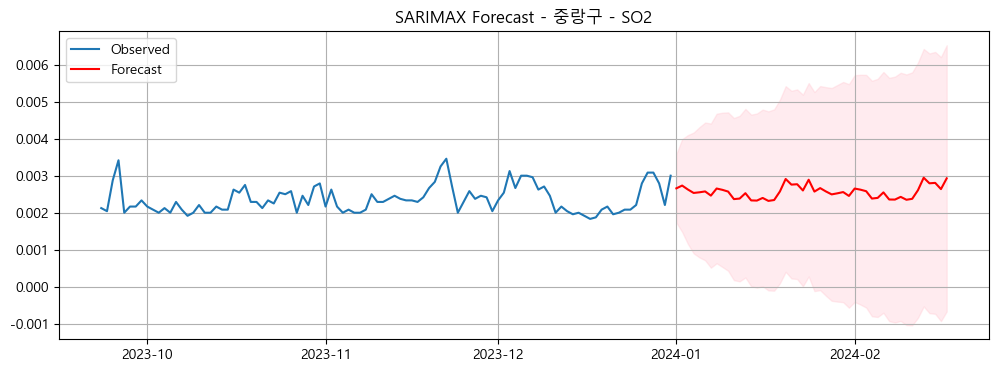


▶ NO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0291 - val_loss: 0.0100
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0142 - val_loss: 0.0101
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0144 - val_loss: 0.0097
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0141 - val_loss: 0.0092
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0130 - val_loss: 0.0107
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0140 - val_loss: 0.0093
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0130 - val_loss: 0.0092
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0131 - val_loss: 0.0088
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0125 - val_loss: 0.0084
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0132 - val_loss: 0.0076
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120 - val_loss: 0.0074
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms

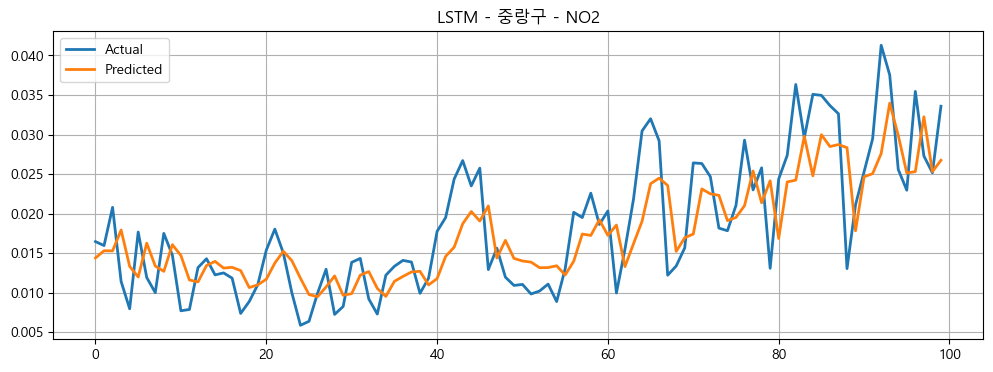

▶ NO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


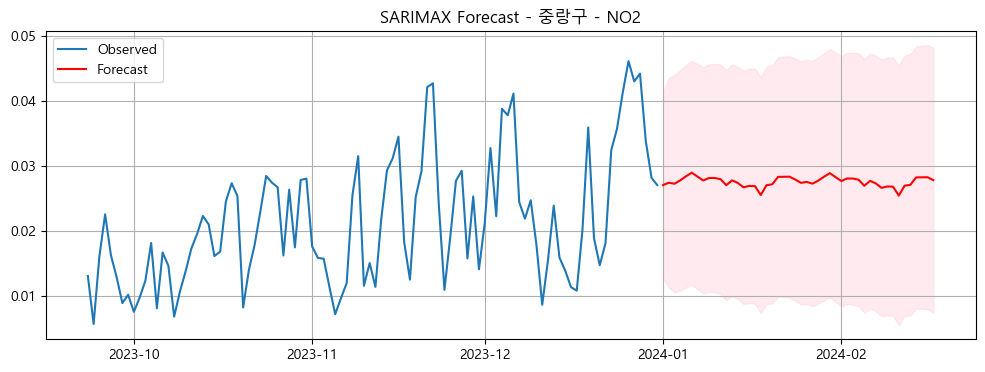


▶ O3 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0367 - val_loss: 0.0207
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0117 - val_loss: 0.0187
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0122 - val_loss: 0.0193
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0114 - val_loss: 0.0188
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0125 - val_loss: 0.0180
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0109 - val_loss: 0.0172
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0115 - val_loss: 0.0180
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0108 - val_loss: 0.0169
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0107 - val_loss: 0.0157
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0104 - val_loss: 0.0176
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - val_loss: 0.0142
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/

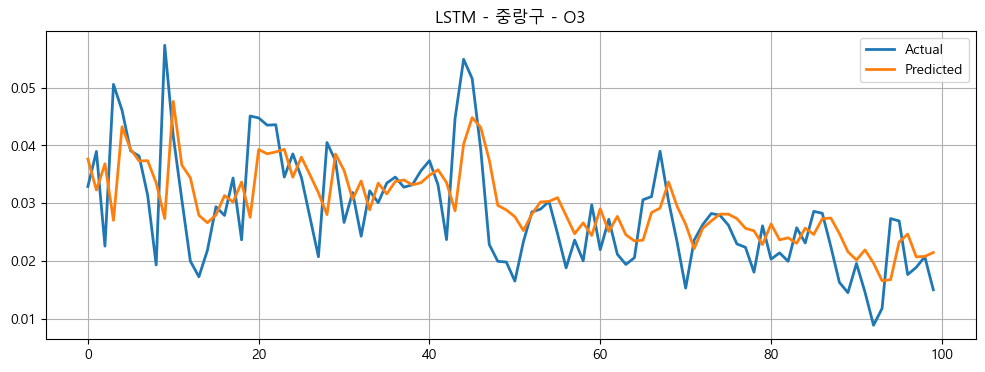

▶ O3 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


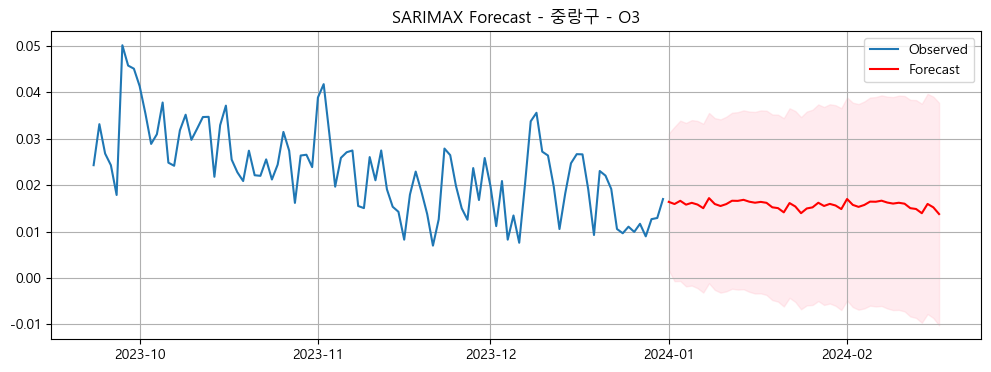


====== 구로구 분석 시작 ======

▶ CO 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0210 - val_loss: 0.0060
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0100 - val_loss: 0.0052
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0091 - val_loss: 0.0049
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0092 - val_loss: 0.0048
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0083 - val_loss: 0.0042
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0073 - val_loss: 0.0034
Epoch 12/50
57/57 ━━━━

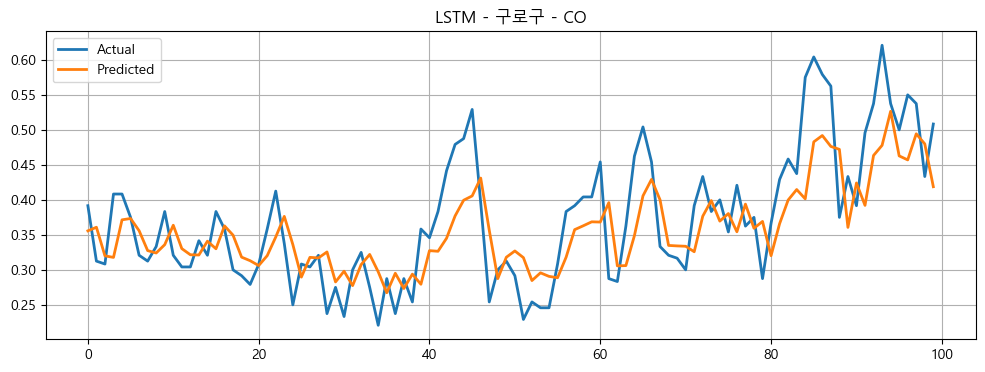

▶ CO 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


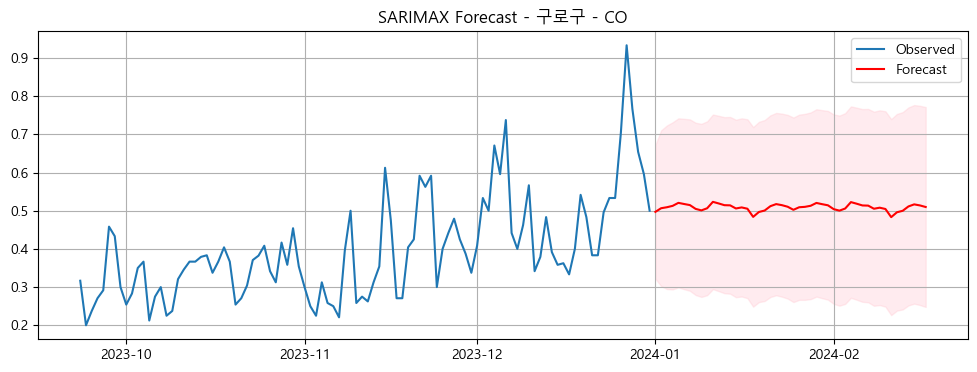


▶ SO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0241 - val_loss: 0.0030
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090 - val_loss: 0.0030
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0082 - val_loss: 0.0029
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0081 - val_loss: 0.0033
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0071 - val_loss: 0.0030
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0082 - val_loss: 0.0027
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0074 - val_loss: 0.0026
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0072 - val_loss: 0.0026
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms

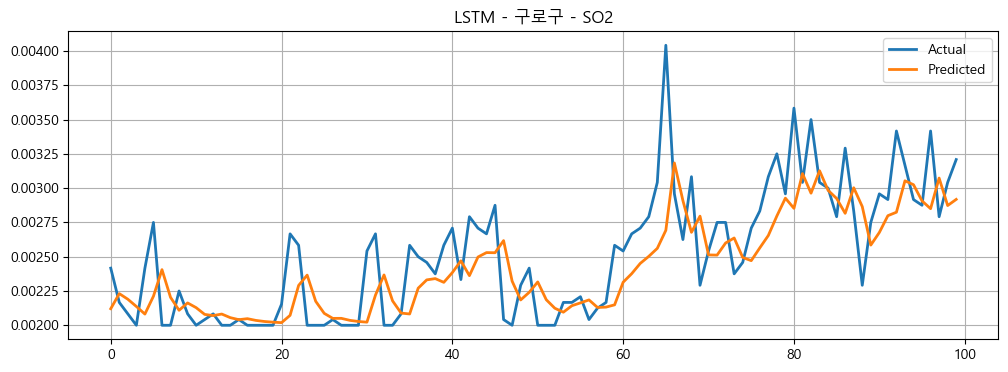

▶ SO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


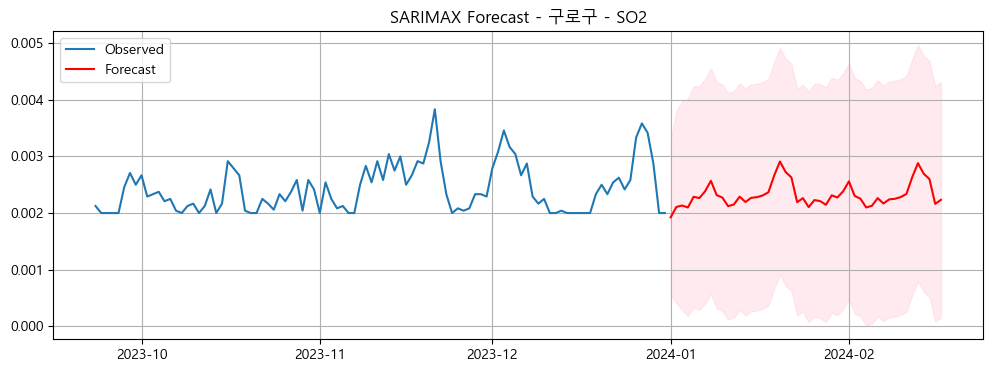


▶ NO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0416 - val_loss: 0.0164
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0225 - val_loss: 0.0154
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0218 - val_loss: 0.0172
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0208 - val_loss: 0.0142
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0210 - val_loss: 0.0175
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0219 - val_loss: 0.0149
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0210 - val_loss: 0.0153
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0205 - val_loss: 0.0130
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0209 - val_loss: 0.0136
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0190 - val_loss: 0.0117
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0184 - val_loss: 0.0109
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

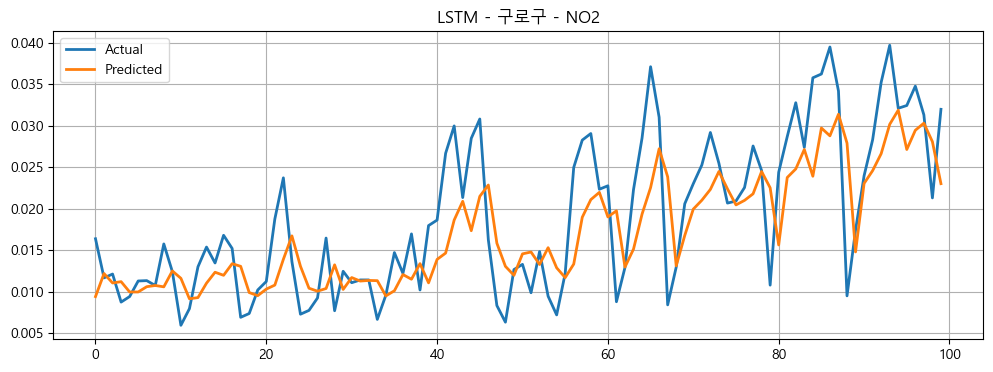

▶ NO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


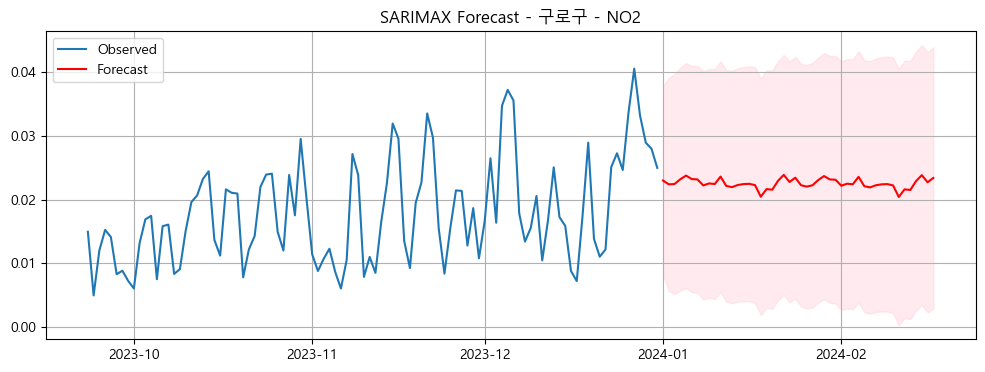


▶ O3 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0299 - val_loss: 0.0159
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0096 - val_loss: 0.0156
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0101 - val_loss: 0.0153
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0092 - val_loss: 0.0150
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0099 - val_loss: 0.0162
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0098 - val_loss: 0.0149
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0093 - val_loss: 0.0146
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0097 - val_loss: 0.0144
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0094 - val_loss: 0.0142
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0094 - val_loss: 0.0140
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0093 - val_loss: 0.0151
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/

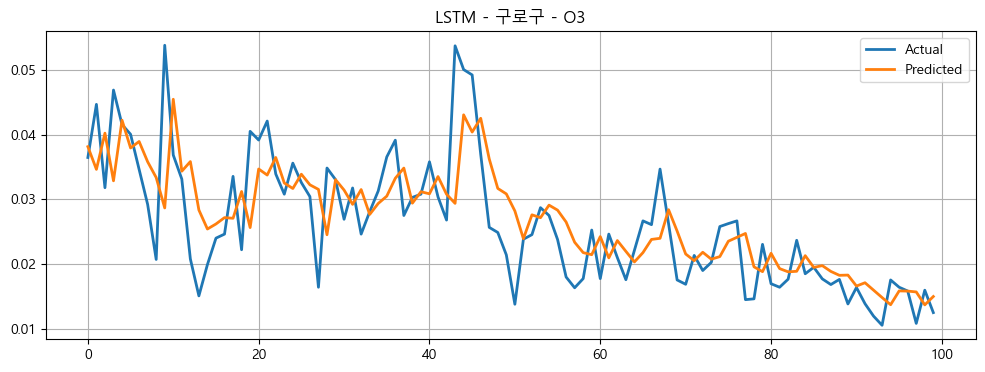

▶ O3 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


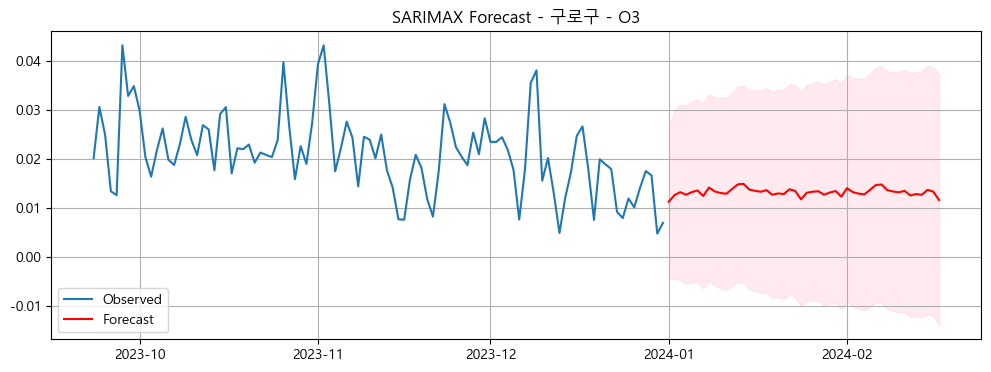


====== 관악구 분석 시작 ======

▶ CO 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0300 - val_loss: 0.0090
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0139 - val_loss: 0.0062
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0121 - val_loss: 0.0057
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0131 - val_loss: 0.0074
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0128 - val_loss: 0.0070
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0117 - val_loss: 0.0070
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0123 - val_loss: 0.0051
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0117 - val_loss: 0.0051
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0115 - val_loss: 0.0053
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0109 - val_loss: 0.0055
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0107 - val_loss: 0.0044
Epoch 12/50
57/57 ━━━━

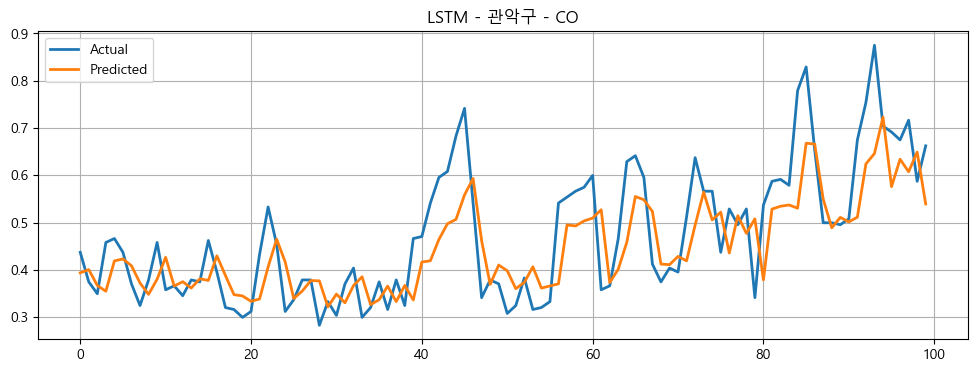

▶ CO 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


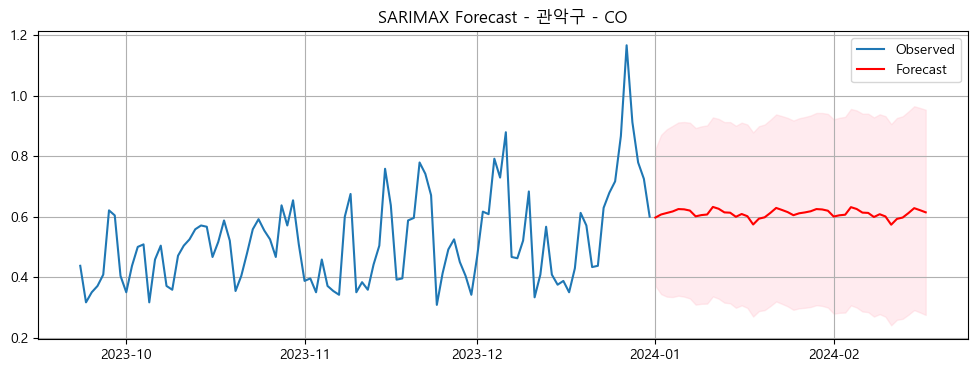


▶ SO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0304 - val_loss: 0.0029
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0080 - val_loss: 0.0026
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0067 - val_loss: 0.0024
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

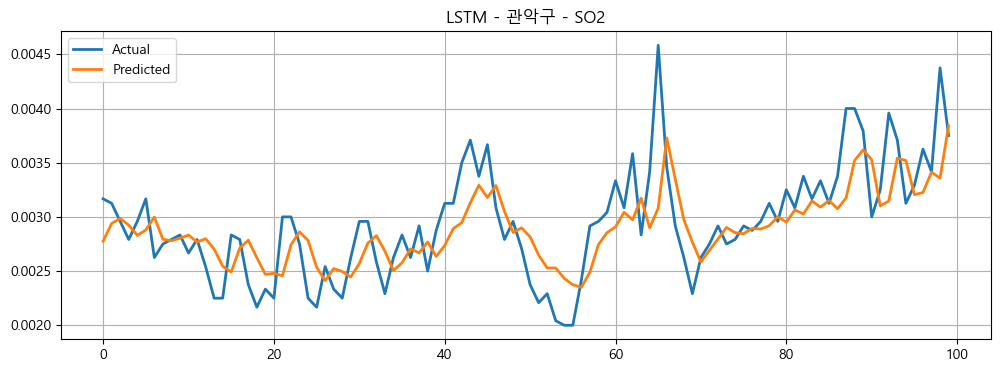

▶ SO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


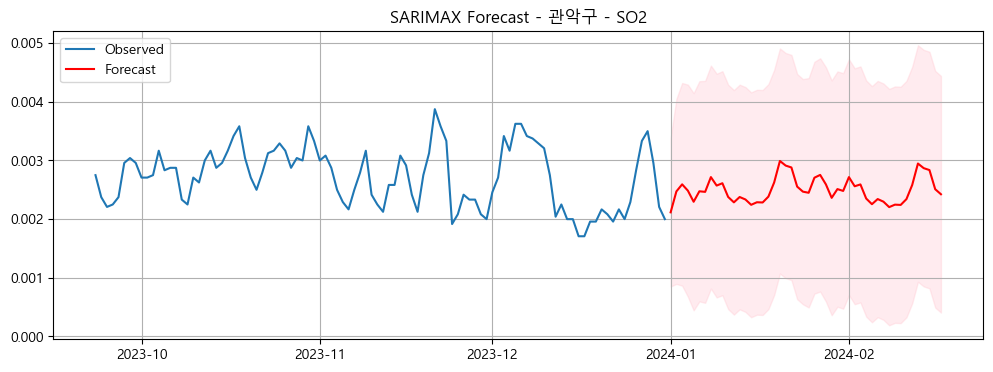


▶ NO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0372 - val_loss: 0.0118
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0196 - val_loss: 0.0129
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0204 - val_loss: 0.0112
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0200 - val_loss: 0.0147
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0194 - val_loss: 0.0144
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0208 - val_loss: 0.0106
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0205 - val_loss: 0.0104
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0179 - val_loss: 0.0092
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0185 - val_loss: 0.0086
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0166 - val_loss: 0.0083
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0157 - val_loss: 0.0078
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

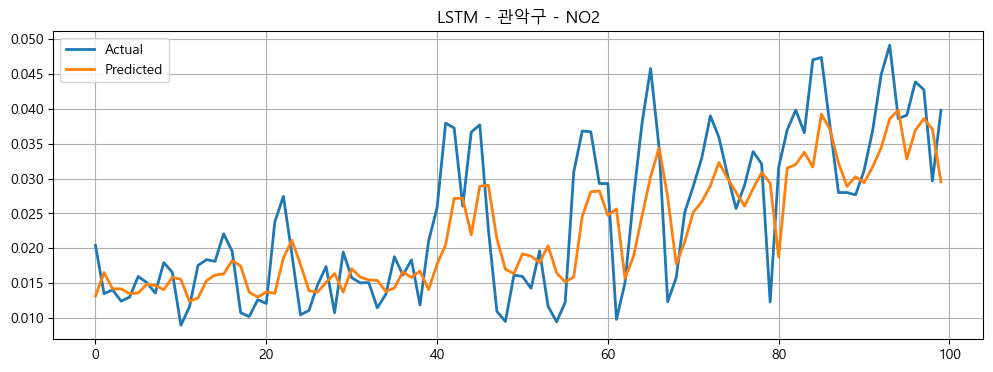

▶ NO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


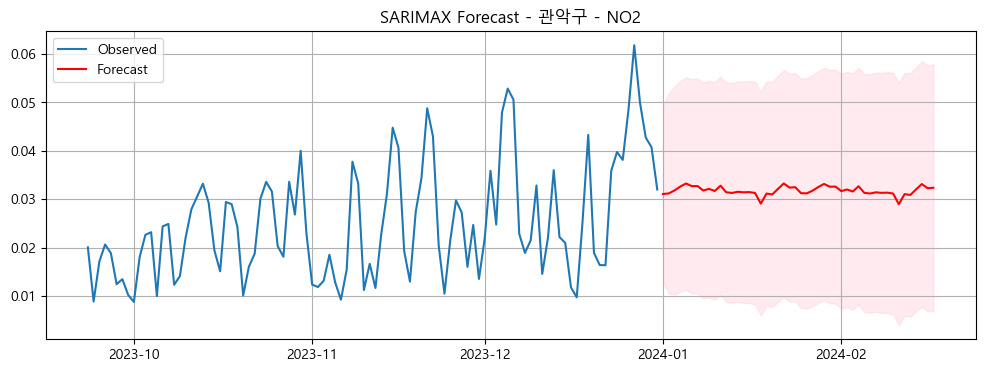


▶ O3 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0365 - val_loss: 0.0154
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0128 - val_loss: 0.0155
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0111 - val_loss: 0.0169
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0111 - val_loss: 0.0149
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0122 - val_loss: 0.0157
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0113 - val_loss: 0.0149
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0108 - val_loss: 0.0140
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0107 - val_loss: 0.0138
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110 - val_loss: 0.0151
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0101 - val_loss: 0.0129
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0095 - val_loss: 0.0123
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/

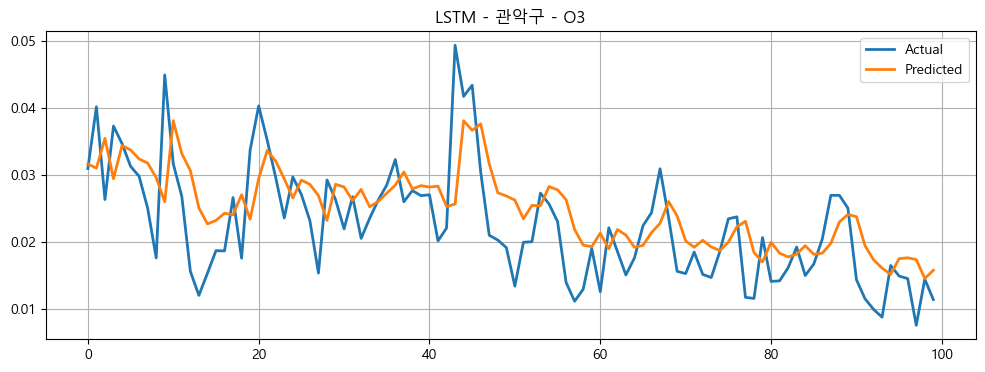

▶ O3 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


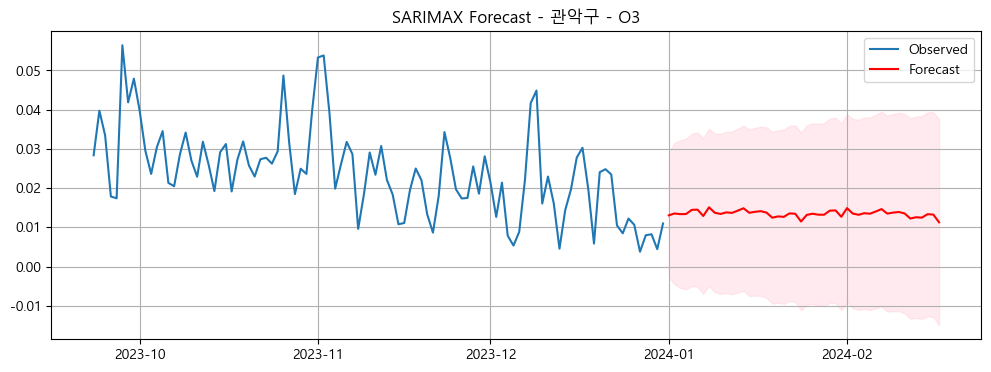


====== 강북구 분석 시작 ======

▶ CO 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0237 - val_loss: 0.0067
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0104 - val_loss: 0.0064
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102 - val_loss: 0.0072
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102 - val_loss: 0.0064
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0100 - val_loss: 0.0060
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0095 - val_loss: 0.0063
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0092 - val_loss: 0.0065
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0077 - val_loss: 0.0046
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 12/50
57/57 ━━━━

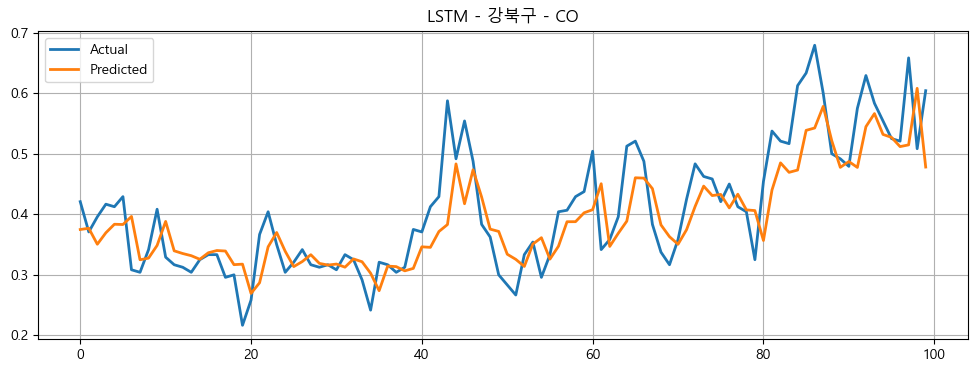

▶ CO 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


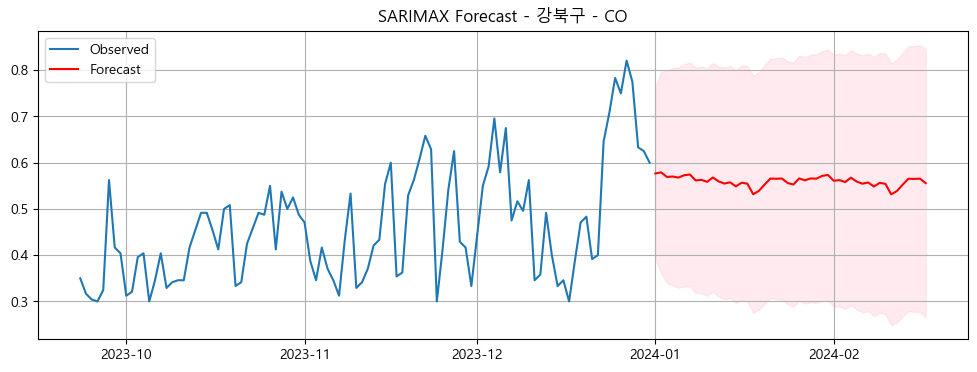


▶ SO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0152 - val_loss: 0.0033
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0071 - val_loss: 0.0030
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066 - val_loss: 0.0029
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms

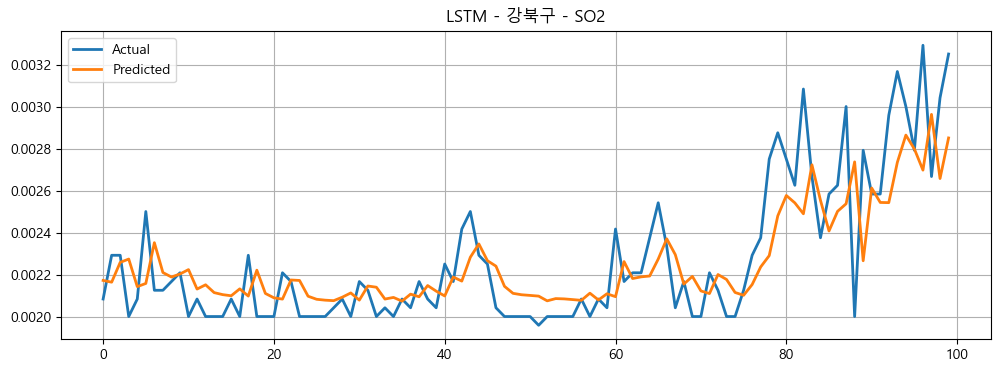

▶ SO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


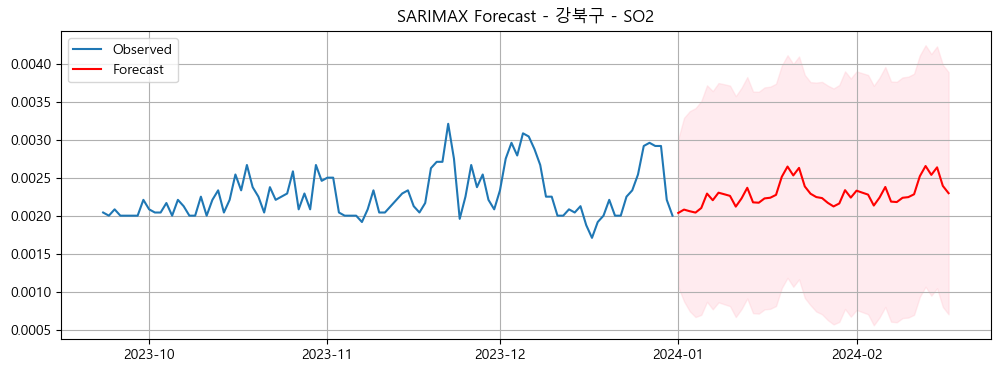


▶ NO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0200 - val_loss: 0.0053
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0119 - val_loss: 0.0052
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0107 - val_loss: 0.0054
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0118 - val_loss: 0.0054
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0113 - val_loss: 0.0050
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0119 - val_loss: 0.0051
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0109 - val_loss: 0.0053
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0107 - val_loss: 0.0049
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0103 - val_loss: 0.0060
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0103 - val_loss: 0.0045
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - val_loss: 0.0049
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

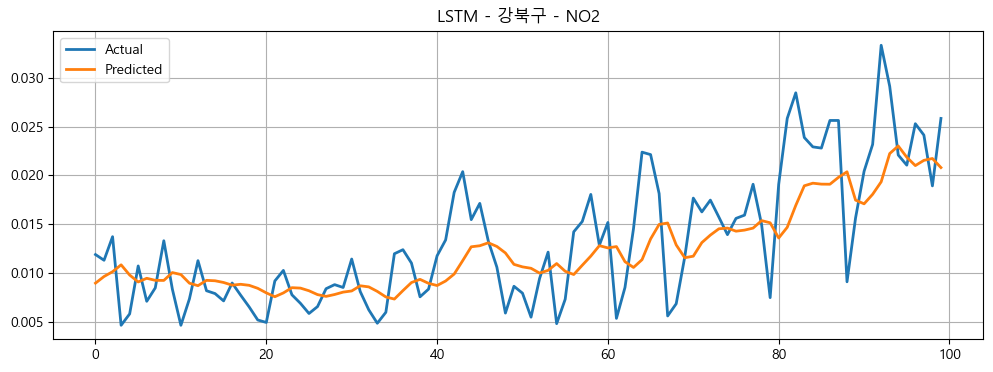

▶ NO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


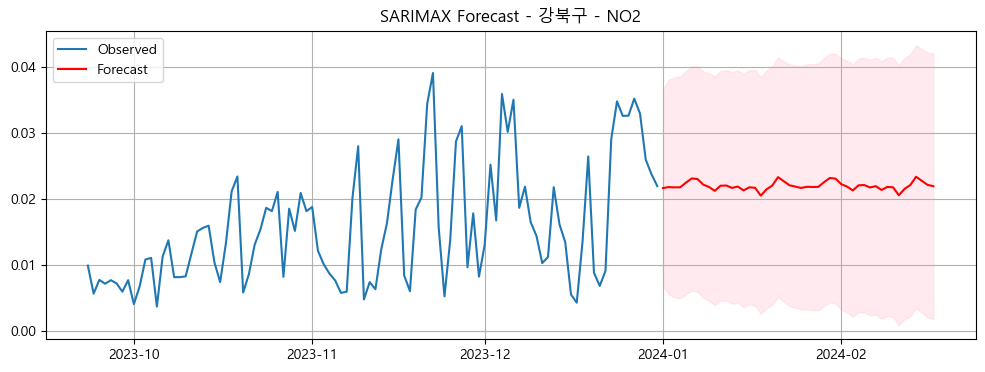


▶ O3 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0479 - val_loss: 0.0187
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0127 - val_loss: 0.0168
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0122 - val_loss: 0.0174
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0124 - val_loss: 0.0165
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0124 - val_loss: 0.0167
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110 - val_loss: 0.0161
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0121 - val_loss: 0.0159
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0122 - val_loss: 0.0172
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0119 - val_loss: 0.0158
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0116 - val_loss: 0.0165
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0126 - val_loss: 0.0161
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/

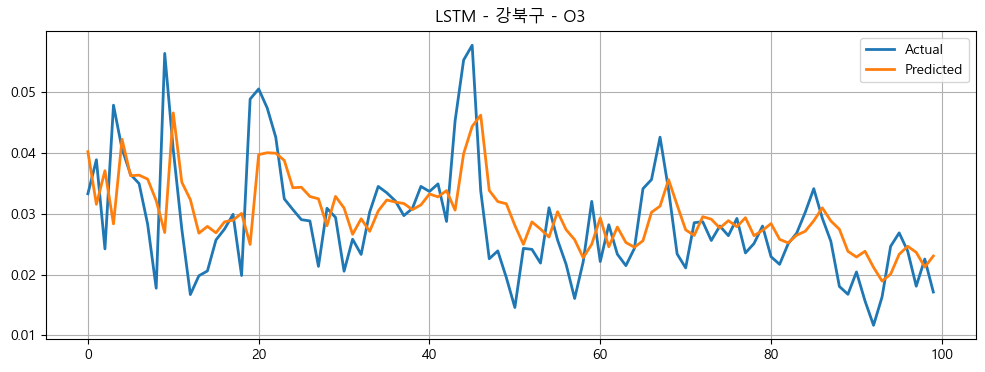

▶ O3 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


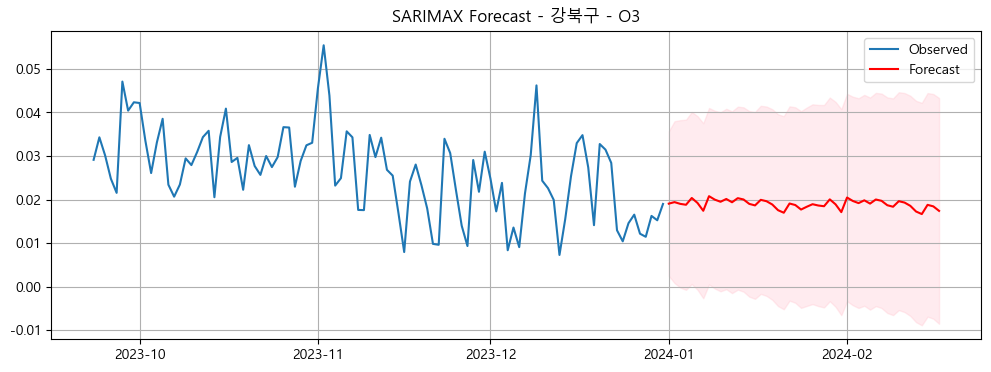


====== 용산구 분석 시작 ======

▶ CO 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0182 - val_loss: 0.0052
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - val_loss: 0.0050
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075 - val_loss: 0.0046
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0079 - val_loss: 0.0050
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069 - val_loss: 0.0040
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 12/50
57/57 ━━━━

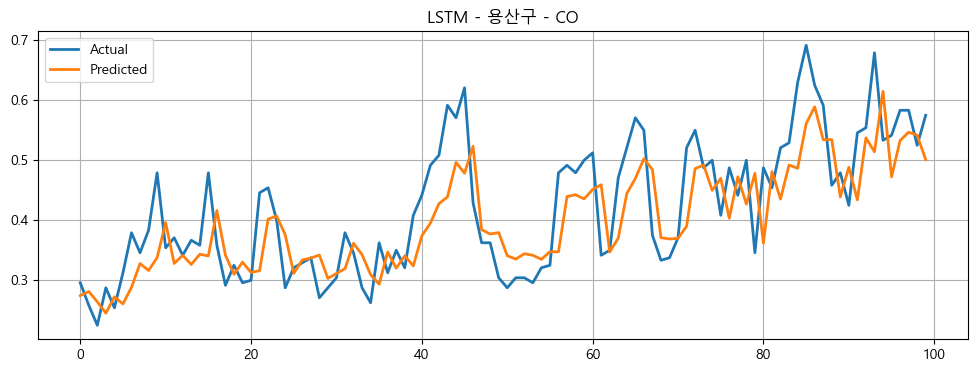

▶ CO 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


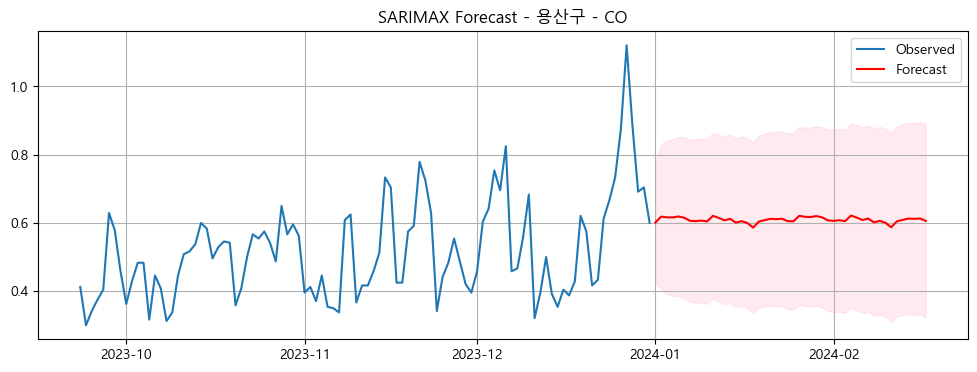


▶ SO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0336 - val_loss: 0.0042
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0133 - val_loss: 0.0041
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0133 - val_loss: 0.0043
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0118 - val_loss: 0.0040
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0115 - val_loss: 0.0042
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0115 - val_loss: 0.0039
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0117 - val_loss: 0.0039
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0115 - val_loss: 0.0039
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0100 - val_loss: 0.0032
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0099 - val_loss: 0.0033
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms

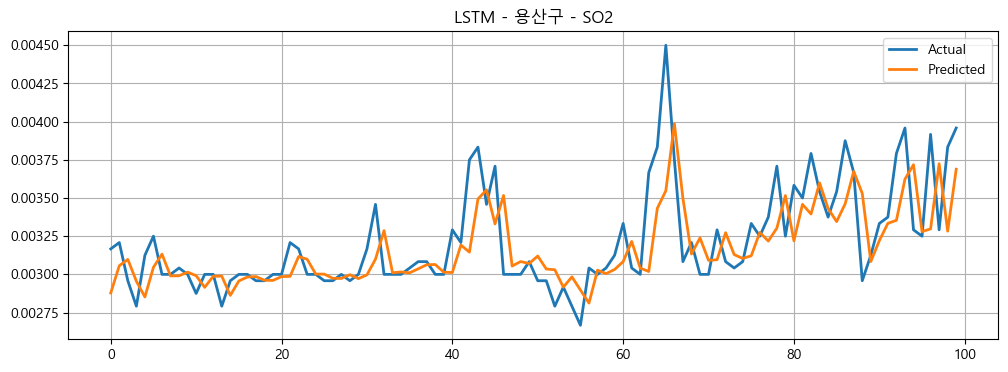

▶ SO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


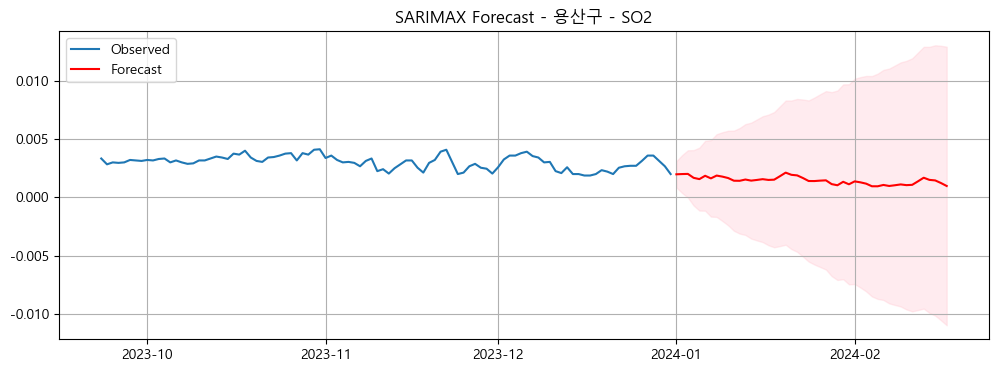


▶ NO2 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0383 - val_loss: 0.0162
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0194 - val_loss: 0.0147
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0192 - val_loss: 0.0153
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0187 - val_loss: 0.0144
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0180 - val_loss: 0.0149
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0187 - val_loss: 0.0132
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0174 - val_loss: 0.0142
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0162 - val_loss: 0.0126
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0169 - val_loss: 0.0124
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0168 - val_loss: 0.0117
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0147 - val_loss: 0.0114
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms

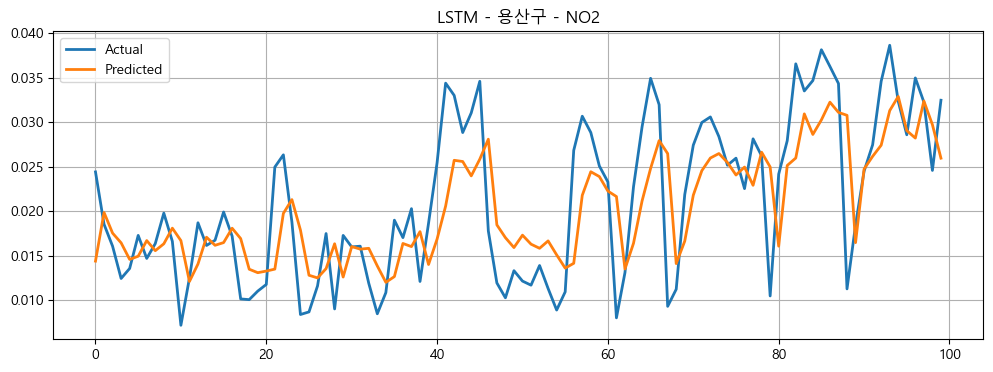

▶ NO2 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


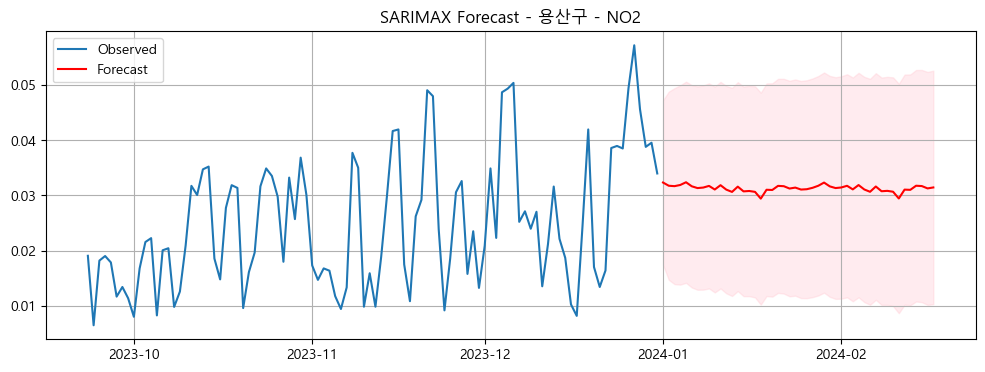


▶ O3 예측 (LSTM)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0286 - val_loss: 0.0223
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0096 - val_loss: 0.0212
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - val_loss: 0.0217
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0089 - val_loss: 0.0197
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0086 - val_loss: 0.0198
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - val_loss: 0.0208
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0087 - val_loss: 0.0192
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0080 - val_loss: 0.0203
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0085 - val_loss: 0.0208
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0079 - val_loss: 0.0208
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0082 - val_loss: 0.0180
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/

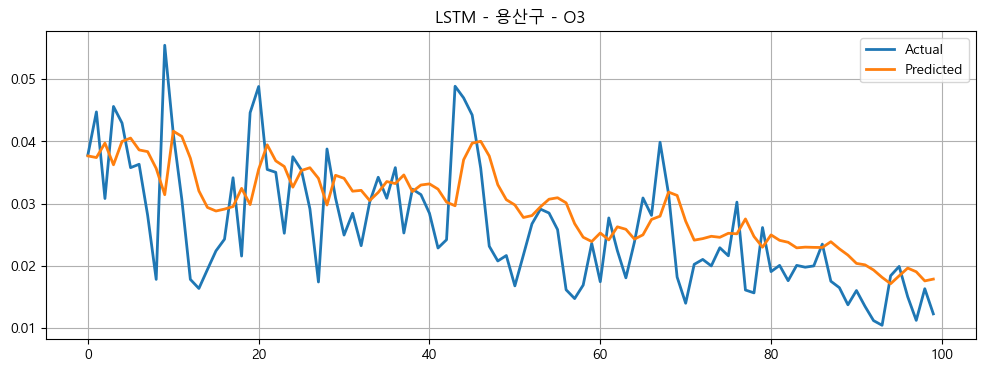

▶ O3 예측 (ARIMA)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


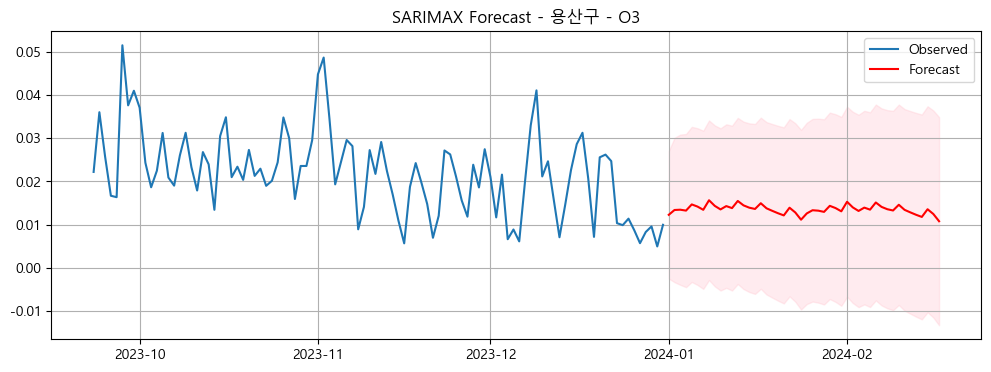

In [19]:
for region in regions:
    df_region = df[df['region'] == region].copy()
    df_region['datetime'] = pd.to_datetime(df_region['datetime'])
    df_region.set_index('datetime', inplace=True)

    print(f"\n====== {region} 분석 시작 ======")

    for pollutant in target_cols:
        print(f"\n▶ {pollutant.upper()} 예측 (LSTM)")

        # NaN 제거 또는 보간
        series = df_region[pollutant].resample('d').mean()
        series = series.interpolate(method='linear')

        lstm_forecast(series, region, pollutant)

        print(f"▶ {pollutant.upper()} 예측 (ARIMA)")
        arima_forecast(series, region, pollutant)  # 동일 시계열 사용

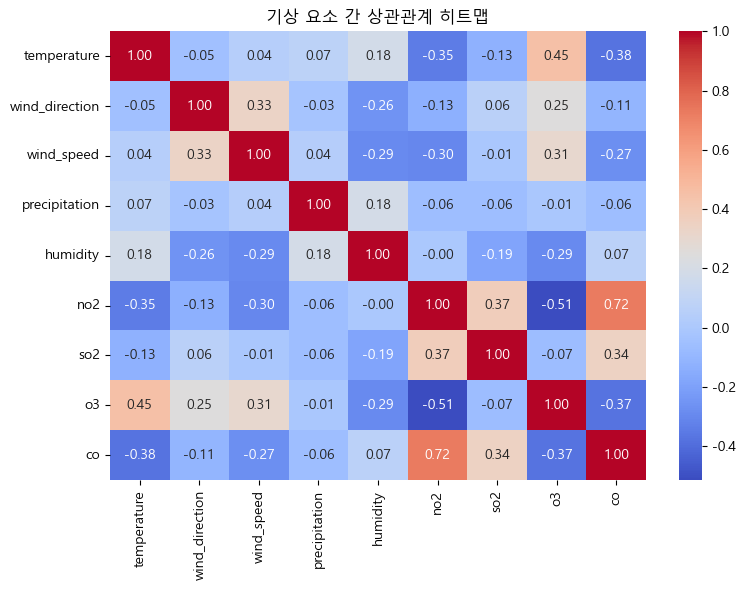

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C:/Users/user-pc/Documents/ai-proj2-class4/20.data-preprocessing/대기오염물질_데이터셋/대기오염물질_데이터셋.csv", encoding="UTF-8")

weather_cols = ['temperature', 'wind_direction', 'wind_speed', 'precipitation', 'humidity', 'no2', 'so2', 'o3', 'co']
df_weather = df[weather_cols]

df_weather = df_weather.dropna()

corr_matrix = df_weather.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("기상 요소 간 상관관계 히트맵")
plt.tight_layout()
plt.show()